In [1]:
import numpy as np
import sys
from casadi import *

# Add do_mpc to path. This is not necessary if it was installed via pip
sys.path.append('../../../')

# Import do_mpc package:
import do_mpc

import matplotlib.pyplot as plt

model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)


In [2]:
# random seed
numpy.random.seed(13)

# parameters
n_sp = 10

# States struct
_N = model.set_variable(var_type='_x', var_name='_N', shape=(n_sp,1))
# (optimization variables)
_u = model.set_variable(var_type='_u', var_name='_u', shape=(n_sp,1))

# draw trait values from uniform random distribution, sort in order
T = np.sort(np.random.uniform(0,1,n_sp)).reshape(n_sp,1)
T
E = 5

def niche_difference(T, E):
    A = np.zeros([len(T), len(T)])

    for i in range(0, len(T)):
        for j in range(0, len(T)):
            if(T[i] != T[j]): 
                A[i,j] = (-1 / (1 + E)) * abs (1 / (T[i] - T[j]))
            else:
                A[i,j] = -1
                
    return(A)

A = niche_difference(T,E)

# intrinsic growth rates
r = np.repeat(1, n_sp).reshape(n_sp,1)

# controllable variables
# initially all uncontrollable
B = np.repeat(0, n_sp).reshape(n_sp,1)
# (species with second-biggest and second-smallest trait values are controllable)
#B[n_sp-1] = 1
#B[0] = 1
B[7] = 1
B[3] = 1

# initial conditions
#x0 = -1*np.linalg.inv(A)@r # set to equilibrium to start
# set to equal abundances to start
x0 = np.repeat(0.25, n_sp).reshape(n_sp,1)

x0

array([[0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25],
       [0.25]])

In [3]:
T

array([[0.23754122],
       [0.45344925],
       [0.60904246],
       [0.64161334],
       [0.72201823],
       [0.77552651],
       [0.77770241],
       [0.82427853],
       [0.9657492 ],
       [0.97260111]])

In [4]:
delta_t = 1e-2
n_step = 1000
n_horizon = 3

# set the differential equation (GLV plus a perturbation to abundance)
model.set_rhs('_N', (_N*(r+A@_N)+B*_u))

# make a CWM target
T_cwm = model.set_expression(expr_name='T_cwm', expr=sum1(T*_N)/sum1(_N) )
N_tot = model.set_expression(expr_name='N_tot', expr=sum1(_N))
richness = model.set_expression(expr_name='richness', expr=sum1(_N>0.01))

# Build the model
model.setup()
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': n_horizon,
    'n_robust': 1,
    'open_loop': 0,
    't_step': delta_t,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    #'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
}

mpc.set_param(**setup_mpc)

In [5]:
mterm = sum1(model.aux['T_cwm'] - 0.5)**2 * 1/model.aux['richness']
lterm = sum1(model.aux['T_cwm'] - 0.5)**2 * 1/model.aux['richness']

#mterm = sum1((model.x['_N'][2])**2)
#lterm = sum1((model.x['_N'][2])**2)

mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(_u=1e-3) # input penalty

min_N = np.repeat(0, n_sp)
max_N = np.repeat(5, n_sp)

min_u = np.repeat(-10, n_sp)
max_u = np.repeat(10, n_sp)

# lower bounds of the states
mpc.bounds['lower','_x','_N'] = min_N

# upper bounds of the states
mpc.bounds['upper','_x','_N'] = max_N

# lower bounds of the input
mpc.bounds['lower','_u','_u'] = min_u

# upper bounds of the input
mpc.bounds['upper','_u','_u'] =  max_u

In [6]:
%%capture

mpc.setup()
estimator = do_mpc.estimator.StateFeedback(model)
simulator = do_mpc.simulator.Simulator(model)

params_simulator = {
    'integration_tool': 'cvodes',
    'abstol': 1e-8,
    'reltol': 1e-8,
    't_step': delta_t
}

simulator.set_param(**params_simulator)

simulator.setup()

mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0

# Use initial state to set the initial guess.
mpc.set_initial_guess()

for k in range(n_step):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

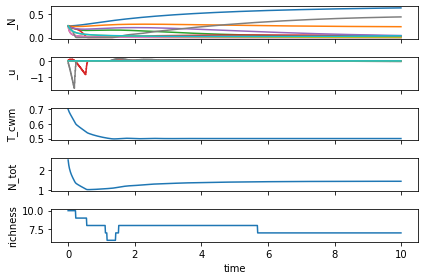

In [7]:
import matplotlib.pyplot as plt
fig, ax, graphics = do_mpc.graphics.default_plot(mpc.data)
graphics.plot_results()
graphics.reset_axes()
plt.show()

In [8]:
preds_statevars = mpc.data['_x']
numpy.savetxt("preds_statevars.csv", preds_statevars, delimiter=",")

preds_perturbations = mpc.data['_u']
numpy.savetxt("preds_perturbations.csv", preds_perturbations, delimiter=",")

preds_time = mpc.data['_time']
numpy.savetxt("preds_time.csv", preds_time, delimiter=",")

numpy.savetxt("preds_traits.csv", T, delimiter=",")

preds_aux = mpc.data['_aux']
numpy.savetxt("preds_aux.csv", preds_aux, delimiter=",")